<h2 align=center>Spoken Term Detection using LSTM and Spacy Modules</h2>

### Task 1: Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf

### Task 2: Loading the Dataset and Pre-processing the data

*Output classes that we'll show in the spacy model*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [3]:
data= pd.read_csv("ner_dataset.csv",encoding="latin1")
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [3]:
print(data.isnull().sum())

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64


In [4]:
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [5]:
print("Unique Words in corpus:",data['Word'].nunique())
print("Unique Tag in corpus:",data['Tag'].nunique())

Unique Words in corpus: 35178
Unique Tag in corpus: 17


In [6]:
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)

In [7]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [8]:
num_words, num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [11]:
#Creating a class to get data in desired formate. i.e. Word,POS,Tag
class SentenceGetter(object):
    def __init__(self,data):
        self.n_sent = 1 #counter
        self.data = data
        agg_func = lambda s:[(w,p,t) for w,p,t in zip(s['Word'].tolist(),s['POS'].tolist(),s['Tag'].tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [12]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [13]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [14]:
word2idx =  {w : i+1 for i,w in enumerate(words)}
tag2idx  =  {t : i for i,t in enumerate(tags)}

In [15]:
word2idx

{'aux': 1,
 'highlands': 2,
 'normalized': 3,
 'perspective': 4,
 'Six-country': 5,
 'painstakingly': 6,
 'liberties': 7,
 'Kandill': 8,
 'Guinean': 9,
 'financier': 10,
 '1,38,000': 11,
 'Sung-ho': 12,
 'sympathizers': 13,
 'ramming': 14,
 'globalization': 15,
 'sovereignty': 16,
 'avert': 17,
 'Aridi': 18,
 'legendary': 19,
 'warmongering': 20,
 'cumulative': 21,
 'residing': 22,
 "L'Equipe": 23,
 'grain': 24,
 'Holodomor': 25,
 'Adde': 26,
 '1878': 27,
 'eternal': 28,
 "N'Djamena": 29,
 'anti-doping': 30,
 'earliest': 31,
 'bamboo': 32,
 'snow-shortened': 33,
 'repairing': 34,
 'strained': 35,
 'Lynch': 36,
 'rejected': 37,
 'pervasive': 38,
 'disposal': 39,
 'Slobodan': 40,
 'Any': 41,
 'revenge': 42,
 'suspected': 43,
 'Network': 44,
 'timeframe': 45,
 'narcotics': 46,
 'Operations': 47,
 'all-night': 48,
 'spearheading': 49,
 'disintegrated': 50,
 'Delhi': 51,
 'sirens': 52,
 'Peres': 53,
 'Queensland': 54,
 'Jovicevic': 55,
 'unsatisfactory': 56,
 'two-man': 57,
 'Odyssey': 58,


### Task 5: Padding Input Sentences and Creating Train/Test Splits


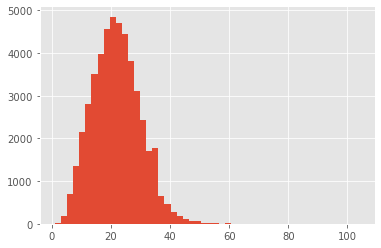

In [16]:
plt.hist([len(s) for s in sentances], bins=50)
plt.show()

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s]for s in sentances]
X = pad_sequences(maxlen = max_len , sequences =X, padding='post', value =num_words-1)

y = [[tag2idx[w[2]] for w in s]for s in sentances]
y = pad_sequences(maxlen = max_len , sequences =y, padding='post', value =tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model 

In [19]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [20]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

### Task 7: Train the Model

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

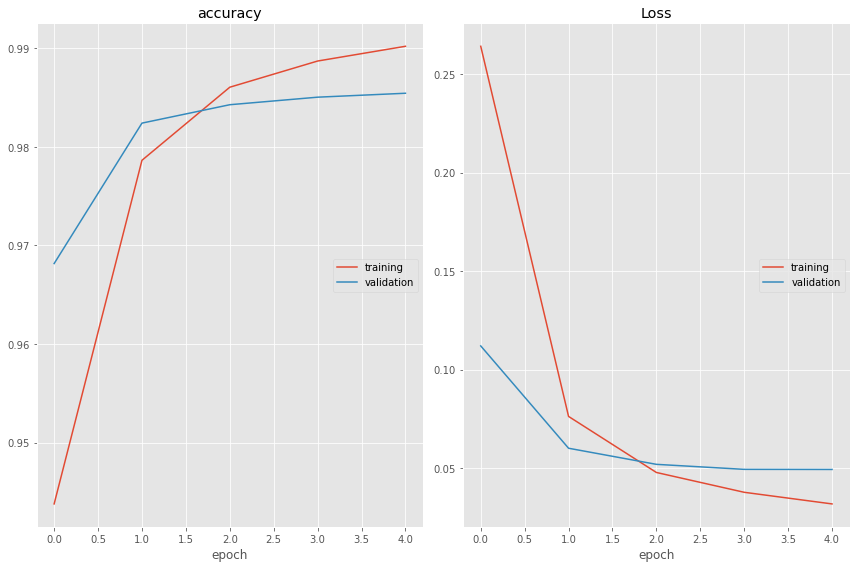

accuracy
	training         	 (min:    0.944, max:    0.990, cur:    0.990)
	validation       	 (min:    0.968, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.032, max:    0.264, cur:    0.032)
	validation       	 (min:    0.049, max:    0.112, cur:    0.049)


In [24]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 64,
    epochs = 5,
    verbose = 1,
    callbacks=callbacks
)

### Task 8: Evaluate Named Entity Recognition Model

In [25]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 3s 21ms/step - loss: 0.0508 - accuracy: 0.9852


[0.050834473222494125, 0.9852085113525391]

In [ ]:
from sklearn.metrics import classification_report
p = model.predict(np.array([x_test[i]]))
classification_report(y_test, p)